In [31]:
import sys
sys.path.append('../')
import numpy as np
import torch
import io
import pickle
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
from utils.plot_config import update_plot_style

from simulators.oup import oup
from simulators.ricker import ricker
from simulators.turin import turin
import warnings
warnings.filterwarnings('ignore')
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
update_plot_style()

cpu


In [9]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_models(root_name: str, device: torch.device):
    sum_net = torch.load("{root_name}/sum_net.pkl".format(root_name=root_name), map_location=device)

    density_estimator = torch.load("{root_name}/density_estimator.pkl".format(root_name=root_name), map_location=device)

    with open("{root_name}/posterior.pkl".format(root_name=root_name), "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior

def sample_posteriors(posterior, obs, num):
    return posterior.sample((num,), x=obs.reshape(1, 1, 100, -1), show_progress_bars=False)

# Figure 1

In [27]:
theta_gt = [4, 10]
obs = np.load("../data/figure_1/obs.npy")
obs_cont = np.load("../data/figure_1/obs_cont.npy")

obs_cont_summary_normal = np.load("../data/figure_1/obs_cont_summary_normal.npy")
obs_cont_summary_robust = np.load("../data/figure_1/obs_cont_summary_robust.npy")

x_summary_normal = np.load("../data/figure_1/x_summary_normal.npy")
x_summary_robust = np.load("../data/figure_1/x_summary_robust.npy")

post_samples_normal_cont = np.load("../data/figure_1/post_samples_normal_cont.npy")
post_samples_robust_cont = np.load("../data/figure_1/post_samples_robust_cont.npy")

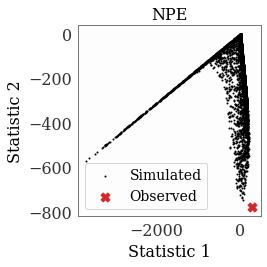

In [35]:
fig, axs = plt.subplots(figsize=(4, 4))

axs.scatter(x_summary_normal[:, 0], x_summary_normal[:, 1], s=1, color='black', label="Simulated")
axs.scatter(obs_cont_summary_normal[0, 0], obs_cont_summary_normal[0, 1], marker='X', s=80, color="C3", label="Observed")
axs.set_title("NPE", fontsize=16)
axs.set_xlabel("Statistic 1")
axs.set_ylabel("Statistic 2")
axs.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.show()
# plt.savefig("npe_summary.pdf", dpi = 300)

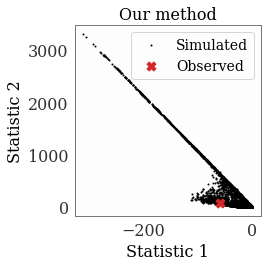

In [36]:
fig, axs = plt.subplots(figsize=(4, 4))

axs.scatter(x_summary_robust[:, 0], x_summary_robust[:, 1], s=1, color='black', label="Simulated")
axs.scatter(obs_cont_summary_robust[0, 0], obs_cont_summary_robust[0, 1], s=80, marker='X', color="C3", label="Observed")
axs.set_title("Our method", fontsize=16)
axs.set_xlabel("Statistic 1")
axs.set_ylabel("Statistic 2")
axs.legend(loc='best', fontsize=14)

plt.tight_layout()
plt.show()
# plt.savefig("npe-rs_summary.pdf", dpi = 300)

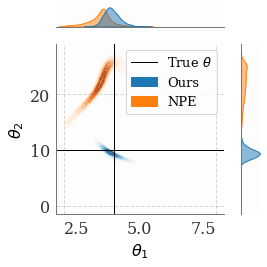

In [38]:
graph = sns.jointplot(x=post_samples_normal_cont[:, 0], y=post_samples_normal_cont[:, 1],
                 cmap="Oranges", kind="kde", height=4, marginal_kws={"color":"C1", "alpha":.5, "shade":True}, shade=True, thresh=0.05, alpha=.5,
                 label='NPE') 

graph.x = post_samples_robust_cont[:, 0]
graph.y = post_samples_robust_cont[:, 1]
graph.plot_joint(sns.kdeplot, cmap="Blues", shade=True, alpha=.5, label='Ours')
graph.ax_joint.axvline(x=theta_gt[0], lw=1, ls="-",c="black", label="True $\\theta$")
graph.ax_joint.axhline(y=theta_gt[1], lw=1, ls="-",c="black")

graph.ax_joint.axvline(x=2, ls="--", lw=1, c="gray", alpha=0.3)
graph.ax_joint.axvline(x=8, ls="--", lw=1, c="gray", alpha=0.3)

graph.ax_joint.axhline(y=0, ls="--", lw=1,c="gray", alpha=0.3)
graph.ax_joint.axhline(y=20, ls="--", lw=1, c="gray", alpha=0.3)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='k', lw=1, label='True $\\theta$'),
                   Patch(facecolor='C0', edgecolor='C0',
                         label='Ours'),
                   Patch(facecolor='C1', edgecolor='C1',
                         label='NPE')]

graph.ax_joint.legend(handles=legend_elements, loc='upper right', fontsize=13) 

graph.ax_joint.set_xlabel('$\\theta_1$')
graph.ax_joint.set_ylabel('$\\theta_2$')

graph.plot_marginals(sns.kdeplot, color='C0', shade=True, alpha=.5, legend=False)
plt.tight_layout()
# plt.savefig("figure2.pdf", dpi = 300)

# Figure 2

In [2]:
# The results are produced by performance_evaluation.ipynb
data_oup_npe_rmse = pd.read_csv('../data/final_results/data_oup_npe_rmse.csv')
data_oup_abc_rmse = pd.read_csv('../data/final_results/data_oup_abc_rmse.csv')
data_oup_npe_mmd = pd.read_csv('../data/final_results/data_oup_npe_mmd.csv')
data_oup_abc_mmd = pd.read_csv('../data/final_results/data_oup_abc_mmd.csv')

data_ricker_npe_rmse = pd.read_csv('../data/final_results/data_ricker_npe_rmse.csv')
data_ricker_abc_rmse = pd.read_csv('../data/final_results/data_ricker_abc_rmse.csv')
data_ricker_npe_mmd = pd.read_csv('../data/final_results/data_ricker_npe_mmd.csv')
data_ricker_abc_mmd = pd.read_csv('../data/final_results/data_ricker_abc_mmd.csv')

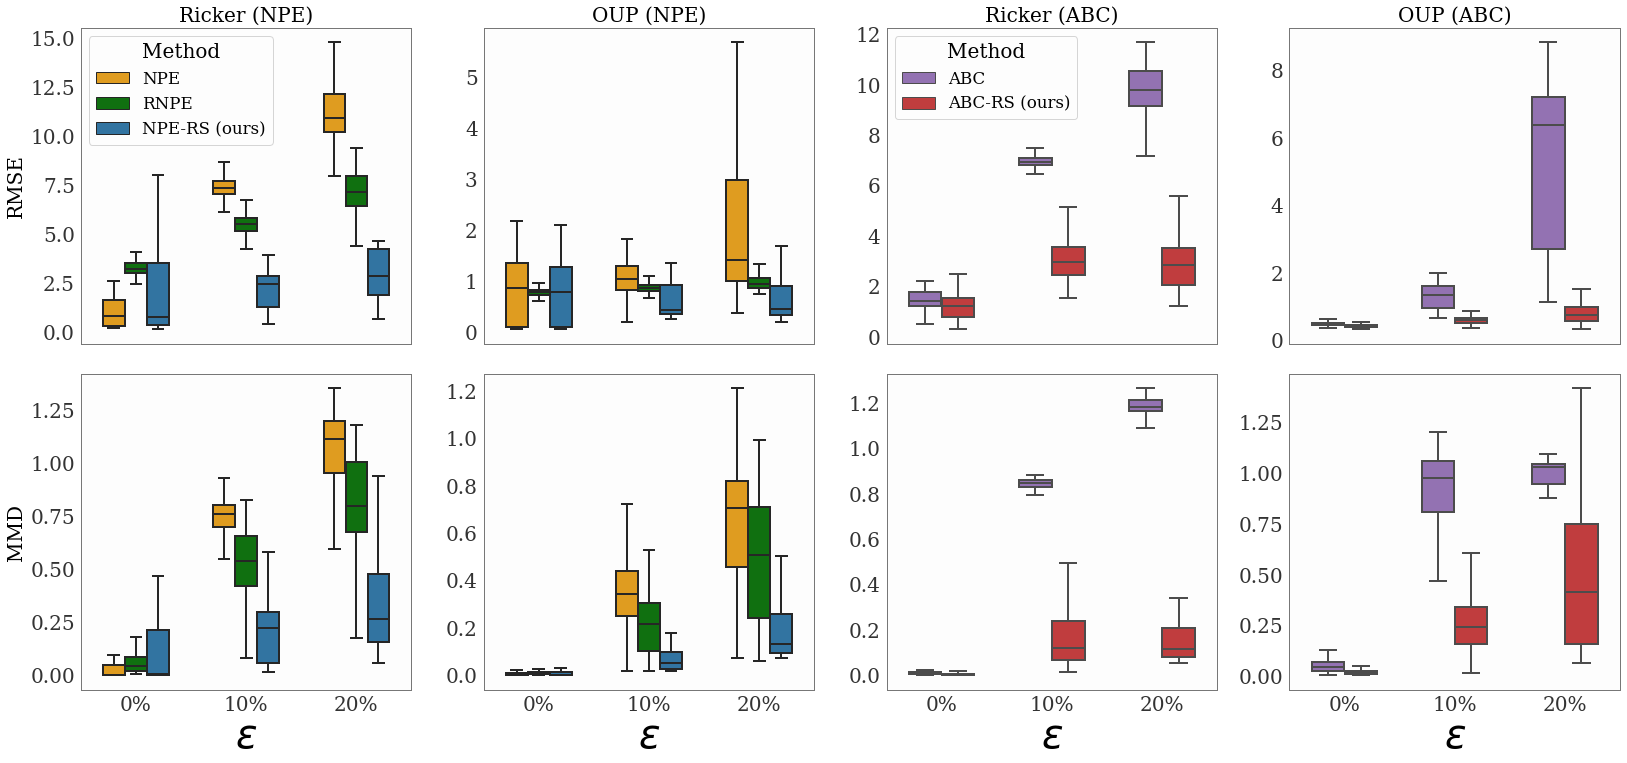

In [3]:
matplotlib.rcParams.update({'font.size' : 20.0,})

npe_pal = {"NPE-RS (ours)": "C0", "RNPE": "green", "NPE":"orange"}
abc_pal = {"ABC-RS (ours)": "C3", "ABC":"C4"}
fig, axes = plt.subplots(2, 4, figsize=(23, 11))


sns.boxplot(ax=axes[0, 0], data=data_ricker_npe_rmse, x='$\epsilon$', y='RMSE', hue='Method', showfliers=False, width=0.6, palette=npe_pal)
axes[0, 0].set_xticks([0, 1, 2], ['', '', ''])
axes[0, 0].set_xlabel(None)
axes[0, 0].set_title("Ricker (NPE)")

sns.boxplot(ax=axes[0, 1], data=data_oup_npe_rmse, x='$\epsilon$', y='RMSE', hue='Method', showfliers=False, width=0.6, palette=npe_pal)
axes[0, 1].set_xticks([0, 1, 2], ['', '', ''])
axes[0, 1].legend([],[], frameon=False)
axes[0, 1].set_xlabel(None)
axes[0, 1].set_ylabel(None)
axes[0, 1].set_title("OUP (NPE)")

sns.boxplot(ax=axes[0, 2], data=data_ricker_abc_rmse, x='$\epsilon$', y='RMSE', hue='Method', showfliers=False, width=0.6, palette=abc_pal)
axes[0, 2].set_ylabel(None)
axes[0, 2].set_xticks([0, 1, 2], ['', '', ''])
axes[0, 2].set_xlabel(None)
axes[0, 2].set_title("Ricker (ABC)")

sns.boxplot(ax=axes[0, 3], data=data_oup_abc_rmse, x='$\epsilon$', y='RMSE', hue='Method', showfliers=False, width=0.6, palette=abc_pal)
axes[0, 3].set_xticks([0, 1, 2], ['', '', ''])
axes[0, 3].set_xlabel(None)
axes[0, 3].set_ylabel(None)
axes[0, 3].legend([],[], frameon=False)
axes[0, 3].set_title("OUP (ABC)")

sns.boxplot(ax=axes[1, 0], data=data_ricker_npe_mmd, x='$\epsilon$', y='MMD', hue='Method', showfliers=False, width=0.6, palette=npe_pal)
axes[1, 0].legend([],[], frameon=False)
axes[1, 0].set_xlabel('$\epsilon$', fontsize=40)

sns.boxplot(ax=axes[1, 1], data=data_oup_npe_mmd, x='$\epsilon$', y='MMD', hue='Method', showfliers=False, width=0.6, palette=npe_pal)
axes[1, 1].set_xlabel('$\epsilon$', fontsize=40)
axes[1, 1].legend([],[], frameon=False)
axes[1, 1].set_ylabel(None)

sns.boxplot(ax=axes[1, 2], data=data_ricker_abc_mmd, x='$\epsilon$', y='MMD', hue='Method', showfliers=False, width=0.6, palette=abc_pal)
axes[1, 2].legend([],[], frameon=False)
axes[1, 2].set_ylabel(None)
axes[1, 2].set_xlabel('$\epsilon$', fontsize=40)

sns.boxplot(ax=axes[1, 3], data=data_oup_abc_mmd, x='$\epsilon$', y='MMD', hue='Method', showfliers=False, width=0.6, palette=abc_pal)
axes[1, 3].set_xlabel('$\epsilon$', fontsize=40)
axes[1, 3].legend([],[], frameon=False)
axes[1, 3].set_ylabel(None)

plt.tight_layout()
plt.savefig("performance.pdf")

# Figure 3 - Ricker NPE posterior plot

In [43]:
post_samples_npe_0 = np.load("../data/ricker/post_samples_npe_degree0.npy")
post_samples_npe_rs_0 = np.load("../data/ricker/post_samples_npe_rs_degree0.npy")
post_samples_rnpe_0 = np.load("../data/ricker/post_samples_rnpe_degree0.npy")


post_samples_npe_1 = np.load("../data/ricker/post_samples_npe_degree1.npy")
post_samples_npe_rs_1 = np.load("../data/ricker/post_samples_npe_rs_degree1.npy")
post_samples_rnpe_1 = np.load("../data/ricker/post_samples_rnpe_degree1.npy")

post_samples_npe_2 = np.load("../data/ricker/post_samples_npe_degree2.npy")
post_samples_npe_rs_2 = np.load("../data/ricker/post_samples_npe_rs_degree2.npy")
post_samples_rnpe_2 = np.load("../data/ricker/post_samples_rnpe_degree2.npy")

In [42]:
def plot_posterior(npe, npe_rs, rnpe, ylim):
    
    theta_gt = [4, 10]
    graph = sns.jointplot(x=rnpe[:, 0], y=rnpe[:, 1], ratio=3,
                     cmap="Greens", kind="kde", height=6, marginal_kws={"color":"C2", "alpha":.5, "shade":True}, shade=True, thresh=0.05, alpha=.5,
                     label='RNPE')      ## CHANGE HERE

    graph.x = npe[:, 0]
    graph.y = npe[:, 1]
    graph.plot_joint(sns.kdeplot, cmap="Oranges", shade=True, alpha=.5, label='NPE')
    graph.plot_marginals(sns.kdeplot, color='C1', shade=True, alpha=.5, legend=False)

    graph.x = npe_rs[:, 0]
    graph.y = npe_rs[:, 1]
    graph.plot_joint(sns.kdeplot, cmap="Blues", shade=True, alpha=.5, label='NPE-RS (ours)')   ## CHANGE HERE
    graph.ax_joint.axvline(x=theta_gt[0], lw=1, ls="-",c="black", label="$\\theta_{\mathrm{true}}$")
    graph.ax_joint.axhline(y=theta_gt[1], lw=1, ls="-",c="black")

    graph.ax_joint.axvline(x=2, ls="--", lw=1, c="gray", alpha=0.3)
    graph.ax_joint.axvline(x=8, ls="--", lw=1, c="gray", alpha=0.3)

    graph.ax_joint.axhline(y=0, ls="--", lw=1,c="gray", alpha=0.3)
    graph.ax_joint.axhline(y=20, ls="--", lw=1, c="gray", alpha=0.3)

    legend_elements = [Line2D([0], [0], color='k', lw=1, label='$\\theta_{\mathrm{true}}$'),

                       Patch(facecolor='C1', edgecolor='C1',
                             label='NPE'),
                       Patch(facecolor='C2', edgecolor='C2',
                             label='RNPE'),
                       Patch(facecolor='C0', edgecolor='C0',
                             label='NPE-RS\n(ours)')]

    graph.ax_joint.legend(handles=legend_elements, loc="upper right", frameon=True, ncol=1, fontsize=15) 


    graph.ax_joint.set_xlabel('$\\theta_1$')
    graph.ax_joint.set_ylabel('$\\theta_2$')
    graph.ax_joint.set_xlim(1.5, 8.5)
    graph.ax_joint.set_ylim(ylim[0], ylim[1])

    graph.plot_marginals(sns.kdeplot, color='C0', shade=True, alpha=.5, legend=False)
    plt.tight_layout()

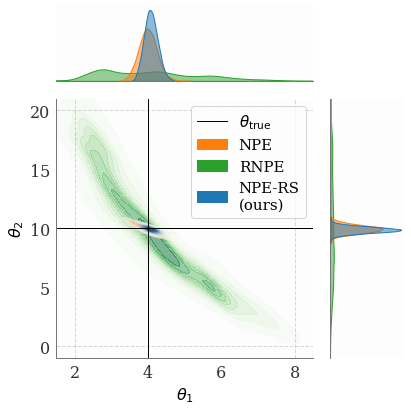

In [44]:
plot_posterior(post_samples_npe_0, post_samples_npe_rs_0, post_samples_rnpe_0, [-1, 21])
# plt.savefig("ricker_npe_0.pdf", bbox_inches = 'tight', dpi = 300)

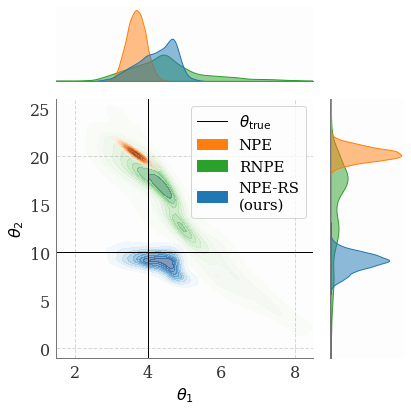

In [46]:
plot_posterior(post_samples_npe_1, post_samples_npe_rs_1, post_samples_rnpe_1, [-1, 26])
# plt.savefig("ricker_1.pdf", bbox_inches = 'tight', dpi = 300)

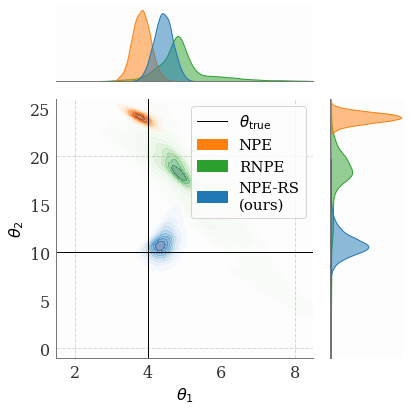

In [47]:
plot_posterior(post_samples_npe_2, post_samples_npe_rs_2, post_samples_rnpe_2, [-1, 26])
# plt.savefig("ricker_2.pdf", bbox_inches = 'tight', dpi = 300)

# Ricker ABC posterior plot

In [48]:
post_samples_abc_0 = np.load("../data/ricker/post_samples_abc_degree0.npy")
post_samples_abc_rs_0 = np.load("../data/ricker/post_samples_abc_rs_degree0.npy")

post_samples_abc_1 = np.load("../data/ricker/post_samples_abc_degree1.npy")
post_samples_abc_rs_1 = np.load("../data/ricker/post_samples_abc_rs_degree1.npy")

post_samples_abc_2 = np.load("../data/ricker/post_samples_abc_degree2.npy")
post_samples_abc_rs_2 = np.load("../data/ricker/post_samples_abc_rs_degree2.npy")

In [49]:
def plot_posterior(abc, abc_rs, ylim):
    theta_gt = [4, 10]
    graph = sns.jointplot(x=abc[:, 0], y=abc[:, 1], ratio=3,
                     color="C4", kind="kde", height=6, marginal_kws={"color":"C4", "alpha":.5, "shade":True}, shade=True, thresh=0.05, alpha=.5,
                     label='ABC')


    graph.x = abc_rs[:, 0]
    graph.y = abc_rs[:, 1]
    graph.plot_joint(sns.kdeplot, color="C3", shade=True, alpha=.5, label='ABC-RS (ours)')   ## CHANGE HERE
    graph.ax_joint.axvline(x=theta_gt[0], lw=1, ls="-",c="black", label="$\\theta_{\mathrm{true}}$")
    graph.ax_joint.axhline(y=theta_gt[1], lw=1, ls="-",c="black")

    graph.ax_joint.axvline(x=2, ls="--", lw=1, c="gray", alpha=0.3)
    graph.ax_joint.axvline(x=8, ls="--", lw=1, c="gray", alpha=0.3)

    graph.ax_joint.axhline(y=0, ls="--", lw=1,c="gray", alpha=0.3)
    graph.ax_joint.axhline(y=20, ls="--", lw=1, c="gray", alpha=0.3)

    legend_elements = [Line2D([0], [0], color='k', lw=1, label='$\\theta_{\mathrm{true}}$'),

                       Patch(facecolor='C4', edgecolor='C4',
                             label='ABC'),
                       Patch(facecolor='C3', edgecolor='C3',
                             label='Ours')]

    graph.ax_joint.legend(handles=legend_elements, loc="upper right", frameon=True, ncol=1, fontsize=17) 


    graph.ax_joint.set_xlabel('$\\theta_1$')
    graph.ax_joint.set_ylabel('$\\theta_2$')
    graph.ax_joint.set_xlim(1.5, 8.5)
    graph.ax_joint.set_ylim(ylim[0], ylim[1])

    graph.plot_marginals(sns.kdeplot, color='C3', shade=True, alpha=.5, legend=False)
    plt.tight_layout()

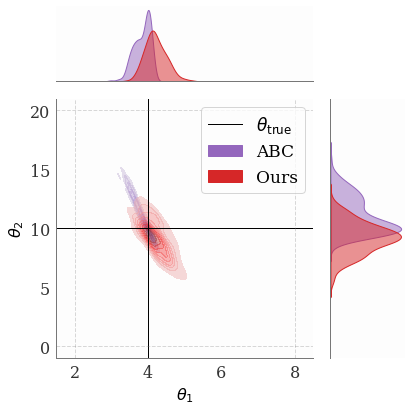

In [50]:
plot_posterior(post_samples_abc_0, post_samples_abc_rs_0, [-1, 21])
# plt.savefig("ricker_abc_0.pdf", bbox_inches = 'tight', dpi = 300)

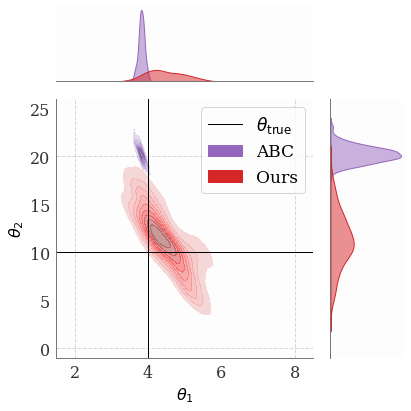

In [52]:
plot_posterior(post_samples_abc_1, post_samples_abc_rs_1, [-1, 26])
# plt.savefig("ricker_abc_1.pdf", bbox_inches = 'tight', dpi = 300)

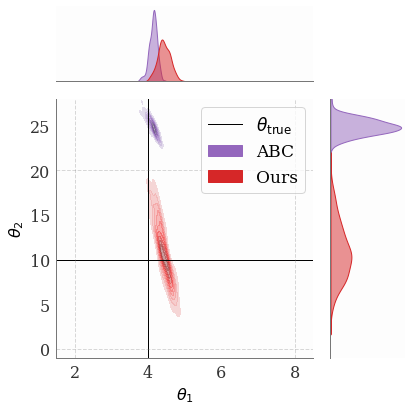

In [54]:
plot_posterior(post_samples_abc_2, post_samples_abc_rs_2, [-1, 28])
# plt.savefig("ricker_abc_2.pdf", bbox_inches = 'tight', dpi = 300)

# Prior misspecification - Ricker NPE

In [55]:
obs_prior_mismatch = np.load("../data/prior_mismatch/obs_prior_mismatch.npy")
post_samples_npe_logn = np.load("../data/prior_mismatch/post_samples_normal.npy")
post_samples_npe_rs_logn = np.load("../data/prior_mismatch/post_samples_robust.npy")
post_samples_rnpe_logn = np.load("../data/prior_mismatch/post_samples_rnpe.npy")

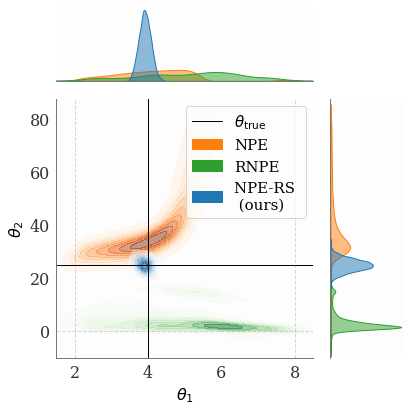

In [56]:
theta_gt = [4, 25]
graph = sns.jointplot(x=post_samples_npe_logn[:, 0], y=post_samples_npe_logn[:, 1], ratio=3,
                 cmap="Oranges", kind="kde", height=6, marginal_kws={"color":"C1", "alpha":.5, "shade":True}, shade=True, thresh=0.05, alpha=.5,
                 label='NPE')      ## CHANGE HERE

graph.x = post_samples_rnpe_logn[:, 0]
graph.y = post_samples_rnpe_logn[:, 1]
graph.plot_joint(sns.kdeplot, cmap="Greens", shade=True, alpha=.5, label='RNPE')
graph.plot_marginals(sns.kdeplot, color='C2', shade=True, alpha=.5, legend=False)


graph.x = post_samples_npe_rs_logn[:, 0]
graph.y = post_samples_npe_rs_logn[:, 1]
graph.plot_joint(sns.kdeplot, cmap="Blues", shade=True, alpha=.5, label='NPE-RS (ours)')   ## CHANGE HERE
graph.ax_joint.axvline(x=theta_gt[0], lw=1, ls="-",c="black", label="$\\theta_{\mathrm{true}}$")
graph.ax_joint.axhline(y=theta_gt[1], lw=1, ls="-",c="black")

graph.ax_joint.axvline(x=2, ls="--", lw=1, c="gray", alpha=0.3)
graph.ax_joint.axvline(x=8, ls="--", lw=1, c="gray", alpha=0.3)

graph.ax_joint.axhline(y=0, ls="--", lw=1,c="gray", alpha=0.3)

legend_elements = [Line2D([0], [0], color='k', lw=1, label='$\\theta_{\mathrm{true}}$'),
                   
                   Patch(facecolor='C1', edgecolor='C1',
                         label='NPE'),
                   Patch(facecolor='C2', edgecolor='C2',
                         label='RNPE'),
                   Patch(facecolor='C0', edgecolor='C0',
                         label='NPE-RS \n (ours)')]

graph.ax_joint.legend(handles=legend_elements, loc='upper right', fontsize=15) 

graph.ax_joint.set_xlabel('$\\theta_1$')
graph.ax_joint.set_ylabel('$\\theta_2$')
graph.ax_joint.set_xlim(1.5, 8.5)

graph.plot_marginals(sns.kdeplot, color='C0', shade=True, alpha=.5, legend=False)
plt.tight_layout()

# plt.savefig("ricker_prior_mismatch.pdf", bbox_inches = 'tight', dpi = 300)

## Lambda/beta analysis

In [16]:
theta_gt = torch.tensor([4, 10])
simulator = ricker(N=100)
obs = simulator(theta_gt).to(device)

x = torch.tensor(np.load("../data/ricker_x_4000.npy")).reshape(-1, 100, 100).to(device)
theta = np.load("../data/ricker_theta_4000.npy")

obs_cont = torch.tensor(np.load("../data/ricker_obs_2.npy"))

prior_samples = torch.tensor(theta[:1000])

betas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
mmd_prior = []
mmd_npe = []
for beta in betas:
    for i in range(1, 51):
        root_name = f"../objects/NPE/ricker/npe_num=1000_2/{i}"
        _, _, posterior_npe = load_models(root_name, device)
        post_samples_npe = sample_posteriors(posterior_npe, obs_cont, 1000)

        root_name = f"../objects/NPE/ricker/mix/degree=0.2_mmd_beta={beta}_theta=[4, 10]_num=1000/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        post_samples_robust = sample_posteriors(posterior_robust, obs_cont, 1000)
        
        mmd_npe.append(float(metrics.MMD_unweighted(post_samples_npe, post_samples_robust, lengthscale=metrics.median_heuristic(post_samples_npe))))
        mmd_prior.append(float(metrics.MMD_unweighted(prior_samples, post_samples_robust, lengthscale=metrics.median_heuristic(prior_samples))))

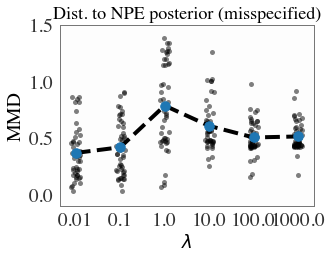

In [21]:
matplotlib.rcParams.update({
    'font.family' : 'times'})
beta_str = ['0.01', '0.1', '1.0', '10.0', '100.0', '1000.0']
y = np.array(mmd_npe).reshape(6, -1)

df = np.array(mmd_npe).reshape(6, -1)
df = pd.melt(pd.DataFrame(df.T, columns=[str(betas[i]) for i in range(df.shape[0])]))
df = df.rename(columns={'value': 'mmd_npe', 'b': 'B'})

plt.figure(figsize=(5, 4))

ax = sns.stripplot(data=df, x="variable", y="mmd_npe", alpha=0.5, color="black")


ax.set_ylim(-0.1, 1.5)

plt.plot(beta_str, np.mean(y, axis=1), color='black', linestyle="--", linewidth=4, )
plt.scatter(beta_str, np.mean(y, axis=1), s=90, color="C0", zorder=10)
ax.set_xlabel("$\lambda$", fontsize=18)
ax.set_ylabel("MMD", fontsize=20)
ax.set_title("Dist. to NPE posterior (misspecified)", fontsize=18)
plt.tight_layout()
# plt.savefig("lambda_check_npe_misspecified.pdf")

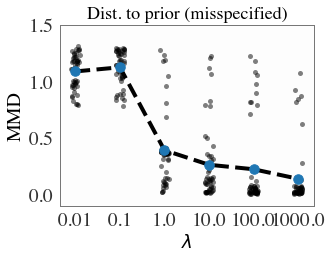

In [22]:
df = np.array(mmd_prior).reshape(6, -1)
df = pd.melt(pd.DataFrame(df.T, columns=[str(betas[i]) for i in range(df.shape[0])]))
df = df.rename(columns={'value': 'mmd_prior', 'b': 'B'})

plt.figure(figsize=(5, 4))

y = np.array(mmd_prior).reshape(6, -1)

ax = sns.stripplot(data=df, x="variable", y="mmd_prior", alpha=0.5, color="black")
plt.scatter(beta_str, np.mean(y, axis=1), s=90, color="C0", zorder=10)
plt.plot(beta_str, np.mean(y, axis=1), color='black', linestyle="--", linewidth=4, )



ax.set_ylim(-0.1, 1.5)

ax.set_xlabel("")
ax.set_ylabel("MMD", fontsize=20)
ax.set_title("Dist. to prior (misspecified)", fontsize=18)
ax.set_xlabel("$\lambda$", fontsize=18)
plt.tight_layout()
# plt.savefig("lambda_check_prior.pdf")

In [24]:
obs = torch.tensor(np.load("../data/ricker_obs_0.npy"))

prior_samples = torch.tensor(theta[:1000])

betas = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
mmd_prior = []
mmd_npe = []
rmse_npe = []
for beta in betas:
    for i in range(1, 51):
        root_name = f"../objects/NPE/ricker/npe_num=1000_1/{i}"
        _, _, posterior_npe = load_models(root_name, device)
        post_samples_npe = sample_posteriors(posterior_npe, obs, 1000)

        root_name = f"../objects/NPE/ricker/mix/degree=0.0_mmd_beta={beta}_theta=[4, 10]_num=1000/{i}"
        _, _, posterior_robust = load_models(root_name, device)
        post_samples_robust = sample_posteriors(posterior_robust, obs, 1000)
        
        mmd_npe.append(float(metrics.MMD_unweighted(post_samples_npe, post_samples_robust, lengthscale=metrics.median_heuristic(post_samples_npe))))
        rmse_npe.append(float(RMSE(theta_gt, post_samples_robust, 2)))

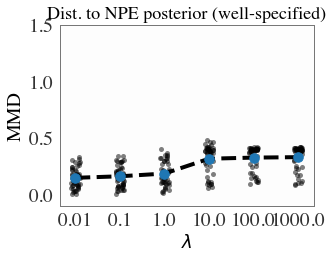

In [25]:
beta_str = ['0.01', '0.1', '1.0', '10.0', '100.0', '1000.0']
y = np.array(mmd_npe).reshape(6, -1)

df = np.array(mmd_npe).reshape(6, -1)
df = pd.melt(pd.DataFrame(df.T, columns=[str(betas[i]) for i in range(df.shape[0])]))
df = df.rename(columns={'value': 'mmd_npe', 'b': 'B'})

plt.figure(figsize=(5, 4))

ax = sns.stripplot(data=df, x="variable", y="mmd_npe", alpha=0.5, color="black")


ax.set_ylim(-0.1, 1.5)  # Set y-axis limits to [0, 1.5]

plt.plot(beta_str, np.mean(y, axis=1), color='black', linestyle="--", linewidth=4, )
plt.scatter(beta_str, np.mean(y, axis=1), s=90, color="C0", zorder=10)
ax.set_xlabel("$\lambda$", fontsize=18)
ax.set_ylabel("MMD", fontsize=20)
ax.set_title("Dist. to NPE posterior (well-specified)", fontsize=18)
plt.tight_layout()
# plt.savefig("lambda_check_npe_wellspecified.pdf")

# Turin

In [57]:
post_samples_npe = torch.tensor(np.load("../data/turin/post_samples_npe.npy"))
post_samples_ours = torch.tensor(np.load("../data/turin/post_samples_ours.npy"))
post_samples_rnpe = torch.tensor(np.load("../data/turin/post_samples_rnpe.npy"))
obs_real = torch.tensor(np.load("../data/turin/turin_obs.npy")).float()

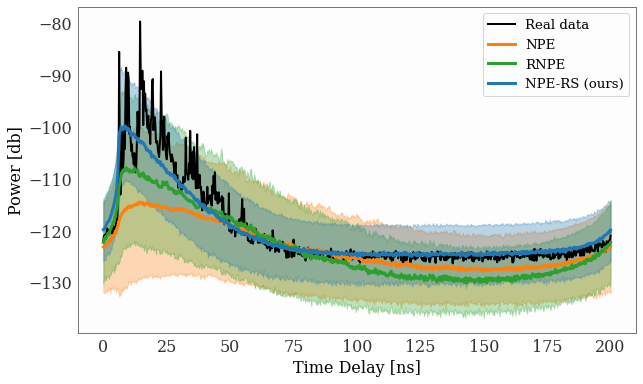

In [59]:
N_samples = 1000
xp = np.linspace(0, 200, 801)

simulator = turin(B=4e9, Ns=801, N=1, tau0=6e-9)
plt.figure(figsize=(10, 6))
plt.plot(xp, torch.mean(obs_real, axis=0), color="black", label="Real data")


npe_mean = torch.zeros([N_samples, 801])
for i in range(N_samples):
    npe_mean[i] = simulator(post_samples_npe[i])
mean = torch.mean(npe_mean, dim=0)
std = torch.std(npe_mean, dim=0)
df = pd.DataFrame({
    'x': xp,
    'y': mean
})

sns.lineplot(df, x="x", y="y", color='C1', alpha=1, linewidth=3, label="NPE")
plt.fill_between(xp, mean - std, mean + std, color='C1', alpha=0.3)


rnpe_mean = torch.zeros([500, 801])
for i in range(500):
    rnpe_mean[i] = simulator(post_samples_rnpe[i])
mean = torch.mean(rnpe_mean, dim=0)
std = torch.std(rnpe_mean, dim=0)
df = pd.DataFrame({
    'x': xp,
    'y': mean
})
sns.lineplot(df, x="x", y="y", color='C2', alpha=1, linewidth=3, label="RNPE")
plt.fill_between(xp, mean - std, mean + std, color='C2', alpha=0.3)

our_mean = torch.zeros([N_samples, 801])
for i in range(N_samples):
    our_mean[i] = simulator(post_samples_ours[i])
mean = torch.mean(our_mean, dim=0)
std = torch.std(our_mean, dim=0)
df = pd.DataFrame({
    'x': xp,
    'y': mean
})
sns.lineplot(df, x="x", y="y",color='C0', alpha=1, linewidth=3, label="NPE-RS (ours)")
plt.fill_between(xp, mean - std, mean + std, color='C0', alpha=0.3)


plt.legend()
plt.xlabel("Time Delay [ns]")
plt.ylabel("Power [db]")
plt.show()
# plt.savefig("turin_predictive.pdf", bbox_inches = 'tight', dpi = 300)

# Expected coverage

In [26]:
def calculate_coverage(post_samples_lp, true_param_lp, alpha, n_samples):
    if float(alpha) == 0:
        return torch.zeros(1).mean()
    elif float(alpha) == 1:
        return torch.ones(1).mean()
    else:
        alpha = 1 - alpha
        cut_off = int(n_samples * alpha)
        logq_samples_sorted, _ = torch.sort(post_samples_lp, dim=0)
        alpha_logprob_min = logq_samples_sorted[cut_off:].min(0).values

        return (alpha_logprob_min < true_param_lp).float().mean()

In [10]:
n_samples = 1000

simulator = oup(N=1)

theta_gt = torch.tensor([0.5, 1.0])

obs = torch.tensor(np.load(f"../data/oup_obs_0.npy"))

confidence_level = np.linspace(0, 1, 101)

npe_coverage = np.zeros(101)
npe_rs_coverage = np.zeros(101)
for i in range(0, n_sim):     
    root_name = f'../objects/NPE/oup_final/degree=0.0_var=1.0_none_beta=3.0_theta=[0.5, 1.0]_num=1000_N=100/{i+1}'
    _, _, posterior_npe = load_models(root_name, device)
    true_lp_npe = posterior_npe.log_prob(theta_gt, x=obs.reshape(1, 1, 100, -1))
    post_samples_npe = sample_posteriors(posterior_npe, obs, n_samples)
    lps_npe = posterior_npe.log_prob(sample_posteriors(posterior_npe, obs, n_samples), x=obs.reshape(1, 1, 100, -1))
    

    root_name = f'../objects/NPE/oup_final/degree=0.0_var=1.0_mmd_beta=1.0_theta=[0.5, 1.0]_num=1000_N=100/{i+1}'
    _, _, posterior_npe_rs = load_models(root_name, device)
    true_lp_npe_rs = posterior_npe_rs.log_prob(theta_gt, x=obs.reshape(1, 1, 100, -1))
    post_samples_npe_rs = sample_posteriors(posterior_npe_rs, obs, n_samples)
    lps_npe_rs = posterior_npe_rs.log_prob(sample_posteriors(posterior_npe_rs, obs, n_samples), x=obs.reshape(1, 1, 100, -1))
    
    for (j,alpha) in enumerate(confidence_level):
        npe_coverage[j] += calculate_coverage(lps_npe, true_lp_npe, alpha, n_samples)
        npe_rs_coverage[j] += calculate_coverage(lps_npe_rs, true_lp_npe_rs, alpha, n_samples)
    

In [13]:
simulator = ricker(N=1)

obs = torch.tensor(np.load(f"../data/ricker_obs_0.npy"))

theta_gt_ricker = torch.tensor([4., 10.])

confidence_level = np.linspace(0, 1, 101)

npe_coverage_ricker = np.zeros(101)
npe_rs_coverage_ricker = np.zeros(101)
for i in range(0, n_sim):   
    
    root_name = f'../objects/NPE/ricker_final/degree=0.0_none_beta=1.0_theta=[4, 10]_num=1000/{i+1}'
    _, _, posterior_npe = load_models(root_name, device)
    true_lp_npe = posterior_npe.log_prob(theta_gt_ricker, x=obs.reshape(1, 1, 100, -1))
    post_samples_npe = sample_posteriors(posterior_npe, obs, n_samples)
    lps_npe = posterior_npe.log_prob(sample_posteriors(posterior_npe, obs, n_samples), x=obs.reshape(1, 1, 100, -1))
        

    root_name = f'../objects/NPE/ricker_final/degree=0.0_mmd_beta=1.0_theta=[4, 10]_num=1000/{i+1}'
    _, _, posterior_npe_rs = load_models(root_name, device)
    true_lp_npe_rs = posterior_npe_rs.log_prob(theta_gt_ricker, x=obs.reshape(1, 1, 100, -1))
    post_samples_npe_rs = sample_posteriors(posterior_npe_rs, obs, n_samples)
    lps_npe_rs = posterior_npe_rs.log_prob(sample_posteriors(posterior_npe_rs, obs, n_samples), x=obs.reshape(1, 1, 100, -1))

    for (j,alpha) in enumerate(confidence_level):
        npe_coverage_ricker[j] += calculate_coverage(lps_npe, true_lp_npe, alpha)
        npe_rs_coverage_ricker[j] += calculate_coverage(lps_npe_rs, true_lp_npe_rs, alpha)

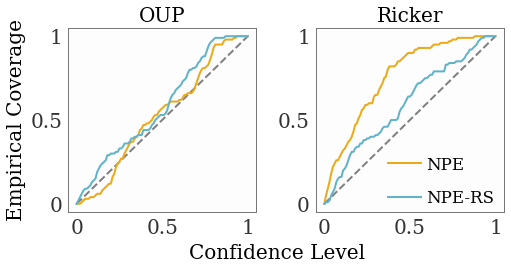

In [14]:
palette = {"NPE-RS": "#ECA918","NPE": "#60B3C8"}

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].set_title("OUP")
ax[0].set_xticks([0, 0.5, 1])
ax[0].set_xticklabels(["0", "0.5", "1"]) 
ax[0].set_yticks([0, 0.5, 1])
ax[0].set_yticklabels(["0", "0.5", "1"])
ax[0].plot([0, 1], [0,1], "--", color="grey", linewidth=2)


ax[0].plot(confidence_level, npe_coverage/100, color="#ECA918", label="NPE")
ax[0].plot(confidence_level, npe_rs_coverage/100, color="#60B3C8", label="NPE-RS")


ax[1].set_title("Ricker")
ax[1].set_xticks([0, 0.5, 1])
ax[1].set_xticklabels(["0", "0.5", "1"]) 
ax[1].set_yticks([0, 0.5, 1])
ax[1].set_yticklabels(["0", "0.5", "1"])
ax[1].plot([0, 1], [0,1], "--", color="grey", linewidth=2)


ax[1].plot(confidence_level, npe_coverage_ricker/100, color="#ECA918")
ax[1].plot(confidence_level, npe_rs_coverage_ricker/100, color="#60B3C8")


fig.legend(
    bbox_to_anchor=[0.97, 0.43],
    markerscale=1.5,
    handletextpad=0.3,
    labelspacing=1,
    frameon=False
    )

fig.set_size_inches(7.5,3.8)
ax[0].set_ylabel("Empirical Coverage")
fig.text(0.54, -0.0, "Confidence Level", ha='center', fontdict={"fontsize": "medium"})
plt.tight_layout()
# plt.savefig("expected_coverage.pdf", dpi = 300)